# Purity State Preparation for Qubits
Quantum Neural Network (QNN) that compute the purity of a given state

In [1]:
import os
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import pennylane as qml
from pennylane import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fmin_l_bfgs_b

import torch
from torch.autograd import Variable
from torch import nn

from create_purity_dataset import generate_density_matrices

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(42)

## Constants

### Dataset

In [4]:
data_folder = "data/discrete"

n_qubits_rho = 1
n_qubits_psi = n_qubits_rho * 2 # for purification
n_qubits_pn = n_qubits_rho * 2 # input: [ρ, ρ]
n_qubits_total = n_qubits_psi * 2
modes_meas = [1,3]

ratio_train = 0.75

### Architectures

In [5]:
hidden_size = 20

## Loading the dataset

### Loading the files

In [6]:
rhos = np.load(os.path.join(data_folder, "rhos.npy"))
purities = np.load(os.path.join(data_folder, "purities.npy"))
list_params = np.load(os.path.join(data_folder, "list_params.npy"))

In [7]:
n_samples = len(rhos)
n_samples_train = int(ratio_train*n_samples)
n_samples_test = n_samples - n_samples_train

In [8]:
samples_idx = np.random.choice(n_samples, size=n_samples, replace=False)
rhos = rhos[samples_idx]
purities = purities[samples_idx]
list_params = list_params[samples_idx]

### Dividing train and test

In [9]:
X_train = list_params[:n_samples_train]
X_test = list_params[n_samples_train:]

Y_train = purities[:n_samples_train]
Y_test = purities[n_samples_train:]
print(len(X_train))

300


## Networks

In [10]:
# dev1 = qml.device('default.qubit', wires=n_qubits_total)
# dev1 = qml.device('projectq.simulator', wires=4)
dev1 = qml.device('forest.wavefunction', wires=4)
# dev1 = qml.device('forest.qvm', device='4q', noisy=False, shots=)

### Universal block

In [11]:
def universal_block(params, q):
    qml.RZ(params[0], wires=q[0])
    qml.RY(params[1], wires=q[0])
    qml.RZ(params[2], wires=q[0])
    qml.RZ(params[3], wires=q[1])
    qml.RY(params[4], wires=q[1])
    qml.RZ(params[5], wires=q[1])
    qml.CNOT(wires=[q[1],q[0]])
    qml.RZ(params[6], wires=q[0])
    qml.RY(params[7], wires=q[1])
    qml.CNOT(wires=[q[0],q[1]])
    qml.RY(params[8], wires=q[1])
    qml.CNOT(wires=[q[1],q[0]])
    qml.RZ(params[9], wires=q[0])
    qml.RY(params[10], wires=q[0])
    qml.RZ(params[11], wires=q[0])
    qml.RZ(params[12], wires=q[1])
    qml.RY(params[13], wires=q[1])
    qml.RZ(params[14], wires=q[1])

### State preparation

In [12]:
def sp_network(params, q):
    universal_block(params, q)

### Purity network

In [13]:
def pn_network(params, q):
    universal_block(params, q)

### End network

In [14]:
import torch.nn.functional as F

In [15]:
class EndNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EndNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        
        for param in self.parameters():
            if len(param.shape) >= 2:
                nn.init.orthogonal_(param.data)
    
    def forward(self, x):
        out = x.float()
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))

        return out

In [26]:
end_network = EndNetwork(len(modes_meas)+1, hidden_size)

In [27]:
end_params = end_network.parameters()

In [18]:
# def end_network(params, x):
#     return params.dot(x)

### Total network

In [34]:
@qml.qnode(dev1, interface='torch')
def total_qnn(sp_params, pn_params):
    sp_network(sp_params, [0,1])
    sp_network(sp_params, [2,3])
    pn_network(pn_params, modes_meas)
    
    ZZ = np.diag([1,-1,-1,1])
#     return (qml.expval.Hermitian(ZZ, wires=modes_meas), qml.expval.PauliZ(1))
    return tuple(qml.expval.PauliZ(mode) for mode in modes_meas) \
         + (qml.expval.Hermitian(ZZ, wires=modes_meas),)
#     return tuple(qml.expval.PauliZ(mode) for mode in modes_meas)

In [35]:
def total_network(sp_params, pn_params):
    return end_network.forward(total_qnn(sp_params, pn_params))

In [36]:
total_network(list_params[1], list_params[0])

tensor([0.0983], grad_fn=<ReluBackward0>)

## Cost and optimizer

### Parameters

In [37]:
pn_params = torch.tensor(np.random.normal(size=15, scale=0.1), requires_grad=True)
# end_params = torch.tensor(np.random.normal(size=len(modes_meas), scale=0.1), requires_grad=True)
# pn_params = np.random.normal(size=15, scale=0.1)
# end_params = np.random.normal(size=len(modes_meas), scale=0.1)

### Cost function

In [38]:
def purity_fct(rho, backend="torch"):
    if backend == "torch":
        return torch.trace(rho @ rho)
    if backend == "np":
        return np.real(np.trace(rho @ rho))

In [39]:
def purity_mse(purity1, purity2):
    return torch.mean((purity1 - purity2)**2)

In [40]:
def cost(sp_params, pn_params, purity_true):
    purity_out = total_network(sp_params, pn_params)
    return purity_mse(purity_out, purity_true)

### Training without gradient

In [41]:
X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train)

In [42]:
def cost_total(params):
    pn_params = params[:15]
    end_params = params[15:]
    return np.mean([cost(X_train_tensor[i], pn_params, Y_train_tensor[i])
                    for i in range(16)])

In [43]:
# import time
# start = time.time()
# result = fmin_l_bfgs_b(cost_total, np.concatenate([pn_params, end_params]),
#                        maxiter=1, approx_grad=True)
# print(time.time() - start)

In [44]:
# result

### Optimizer

In [45]:
opt = torch.optim.Adam([pn_params] + list(end_network.parameters()), lr = 0.1)

In [46]:
pn_params

tensor([-0.0794, -0.0368,  0.0157, -0.0115,  0.0832, -0.0319, -0.0205,  0.0271,
         0.2245, -0.0788,  0.1924, -0.1184,  0.0229, -0.0339, -0.0815],
       dtype=torch.float64, requires_grad=True)

## Training

In [47]:
cost_train_list = []
cost_test_list = []
iter_train_list = []
iter_test_list = []
i = 0

In [103]:
nb_epochs = 30000
lr = 100e-4
batch_size = 16
n_iters_test = 2
opt.lr = lr

for i in range(i, nb_epochs+i):
    samples_idx = np.random.choice(n_samples_train, size=n_samples_train, replace=False)
    
    opt.zero_grad()
    cost_train_epoch = []
    cost_train_batch = 0
    for i_sample in range(n_samples_train):
        sp_params = torch.tensor(X_train[samples_idx[i_sample]])
        purity_true = torch.tensor(Y_train[samples_idx[i_sample]])
      
        cost_train_batch += cost(sp_params, pn_params, purity_true) 

        if (i_sample != 0 and i_sample % batch_size == 0) or i_sample == n_samples_train-1:
            cost_train_epoch.append(cost_train_batch.detach().numpy() / batch_size)
            clear_output(wait=True)
            print('Step: {}/{}'.format(i_sample, n_samples_train))
            print('Cost train after step {:5d}: {: .7f}'.format(i, np.mean(cost_train_epoch)))
            if i > n_iters_test:
                print('Cost test after step {:5d}: {: .7f}'.format(i, cost_test_list[-1]))  
            
            cost_train_batch.backward()
            opt.step()
            opt.zero_grad()
            cost_train_batch = 0
            
    if i % n_iters_test == 0:
        samples_idx = np.random.choice(n_samples_test, size=n_samples_test, replace=False)
        cost_test_sample = []
        for i_sample in range(n_samples_test):
            sp_params = torch.tensor(X_test[samples_idx[i_sample]])
            purity_true = torch.tensor(Y_test[samples_idx[i_sample]])
            cost_test_sample.append(cost(sp_params, pn_params, purity_true).detach().numpy())
        cost_test_list.append(np.mean(cost_test_sample))
        iter_test_list.append(i)
        
    cost_train_list.append(np.mean(cost_train_epoch))
    iter_train_list.append(i)
    
i = i+1

Step: 192/300
Cost train after step    50:  0.0001371
Cost test after step    50:  0.0000082


KeyboardInterrupt: 

# Visualization and result

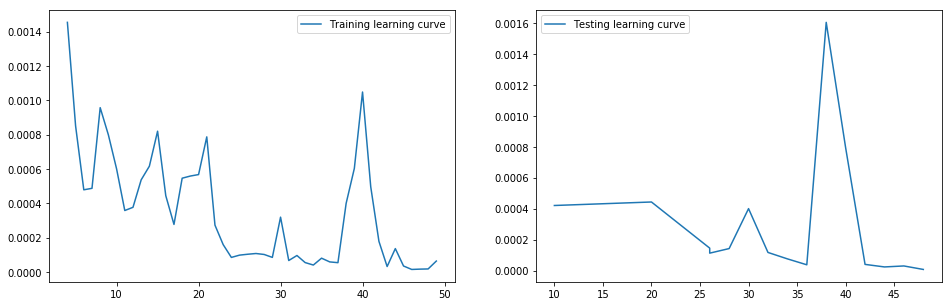

In [104]:
start = 4
plt.rcParams['figure.figsize'] = (16,5)

plt.subplot(1,2,1)
plt.plot(iter_train_list[start:], cost_train_list[start:], 
         label="Training learning curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(iter_test_list[np.where(np.array(iter_test_list) >= start)[0][0]:], cost_test_list[np.where(np.array(iter_test_list) >= start)[0][0]:], 
         label="Testing learning curve")
plt.legend()

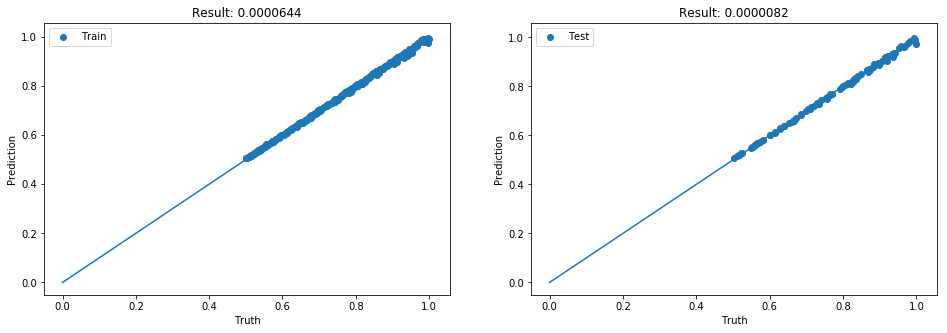

In [107]:
plt.rcParams['figure.figsize'] = (16,5)

plt.subplot(1,2,1)
plt.title("Result: {:0.7f}".format(cost_train_list[-1]))

purity_pred = []
for j in range(n_samples_train):
    purity_pred.append(total_network(torch.tensor(X_train[j]), pn_params).detach().numpy())

plt.scatter(Y_train, purity_pred, label="Train")
plt.plot([0,1],[0,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.legend()

plt.subplot(1,2,2)
plt.title("Result: {:0.7f}".format(cost_test_list[-1]))

purity_pred = []
for j in range(n_samples_test):
    purity_pred.append(total_network(torch.tensor(X_test[j]), pn_params).detach().numpy())
    
plt.scatter(Y_test, purity_pred, label="Test")
plt.plot([0,1],[0,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.legend()

plt.savefig("experiments/discrete/non_linear_zz_net/truth-predict.png")

## Debug